# <center>Group Project 1: Supervised Learning</center>
## <center>Josh Melton and Ivan Benitez</center>  

### Part 1: Breast Cancer Data
#### a) Data Preparation
First, read the breast cancer data csv into a pandas dataframe:
- Set the column names
- Index using the 'id' column
- Remove the Unnamed column

In [1]:
import pandas as pd

cancer_data = pd.read_csv('breastcancer_data.csv',
                          header=0,
                          index_col=0)
cancer_data.drop(cancer_data.filter(regex='Unnamed'),
                 axis=1, inplace=True)
# cancer_data.info()

Then, split the data into our class labels and data features.

Our class label is the 'diagnosis' column, which has two classes: Metastatic (M) and Benign (B).  
For simplicity, the metastatic class is converted to 1 and the benign class to 0.

In [2]:
labels = cancer_data['diagnosis']
labels.replace('M', 1, inplace=True)
labels.replace('B', 0, inplace=True)

features = cancer_data.drop('diagnosis', axis=1)

Next, split the data into training and tests sets for fitting and testing our models.

In [3]:
from sklearn import model_selection as ms

X_train, X_test, y_train, y_test = ms.train_test_split(features, labels,
                                                       test_size=0.2,
                                                       random_state=123)

#### b) Naive Bayes Model

Initialize and fit the Gaussian Naive Bayes model to the training data.  
Then evaluate the model's performance on the test set.

In [4]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred_gnb = gnb.predict(X_test)

def print_metrics(labels, preds):
    """
        Prints confusion matrix and metrics scores for a binary classification
    """
    scores = metrics.precision_recall_fscore_support(labels, preds)
    conf = metrics.confusion_matrix(labels, preds)
    print(' ' * 4 + 'Confusion Matrix')
    print(' ' * 17 + 'Predict Positive    Predict Negative')
    print('Actual Positive         {}                 {}'.format(conf[1, 1], conf[1, 0]))
    print('Actual Negative         {}                 {}'.format(conf[0, 1], conf[0, 0]))
    print()
    print('Accuracy: {:.3f}'.format(metrics.accuracy_score(labels, preds)))
    print()
    print(' ' * 4 + 'Classification Report')
    print(' ' * 11 + 'Positive    Negative')
    print('Num cases    {}           {}'.format(scores[3][1], scores[3][0]))
    print('Precision    {:.2f}       {:.2f}'.format(scores[0][1], scores[0][0]))
    print('Recall       {:.2f}       {:.2f}'.format(scores[1][1], scores[1][0]))
    print('F1 Score     {:.2f}       {:.2f}'.format(scores[2][1], scores[2][0]))

print_metrics(y_test, y_pred_gnb)

    Confusion Matrix
                 Predict Positive    Predict Negative
Actual Positive         36                 5
Actual Negative         0                 73

Accuracy: 0.956

    Classification Report
           Positive    Negative
Num cases    41           73
Precision    1.00       0.94
Recall       0.88       1.00
F1 Score     0.94       0.97


Finally, run 5-fold cross-validation on the entire dataset to evaluate the model's performance.  
F1, precision, recall, and accuracy scores are reported for each fold as well as the mean score across all folds.

In [5]:
scoring = ['f1', 'precision', 'recall', 'accuracy']
gnb_cv_scores = ms.cross_validate(gnb, features, labels,
                                  cv=5, scoring=scoring)

def print_cv_scores(results):
    """
        Prints scoring metrics from cross-validation 
    """
    f1 = results['test_f1']
    precision = results['test_precision']
    recall = results['test_recall']
    accuracy = results['test_accuracy']

    print(' ' * 4 + 'Cross Validation Scores')
    print(' ' * 9 + 'F1     Precision    Recall    Accuracy')
    for i, (f, p, r, a) in enumerate(zip(f1, precision, recall, accuracy)):
        print('Fold {}   {:.3f}    {:.3f}      {:.3f}     {:.3f}'.format(i+1, f, p, r, a))
    print()
    print('Mean F1: {:.3f}'.format(f1.mean()))
    print('Mean Precision: {:.3f}'.format(precision.mean()))
    print('Mean Recall: {:.3f}'.format(recall.mean()))
    print('Mean Accuracy: {:.3f}'.format(accuracy.mean()))

print_cv_scores(gnb_cv_scores)

    Cross Validation Scores
         F1     Precision    Recall    Accuracy
Fold 1   0.897    0.886      0.907     0.922
Fold 2   0.886    0.972      0.814     0.922
Fold 3   0.938    0.974      0.905     0.956
Fold 4   0.927    0.950      0.905     0.947
Fold 5   0.940    0.951      0.929     0.956

Mean F1: 0.917
Mean Precision: 0.947
Mean Recall: 0.892
Mean Accuracy: 0.940


#### d) K-Nearest Neighbors Model

Initialize and fit the KNN model to the training data. Run 5-fold cross validation to tune the optimal
number of neighbors, refitting the model based on the best F1 score.

In [6]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

knn = ms.GridSearchCV(estimator=KNeighborsClassifier(),
                      param_grid={'n_neighbors': range(1, 10, 2)},
                      cv=5, scoring=scoring, refit='f1')
knn.fit(X_train, y_train)
print('Best k:', knn.best_params_)

Best k: {'n_neighbors': 7}


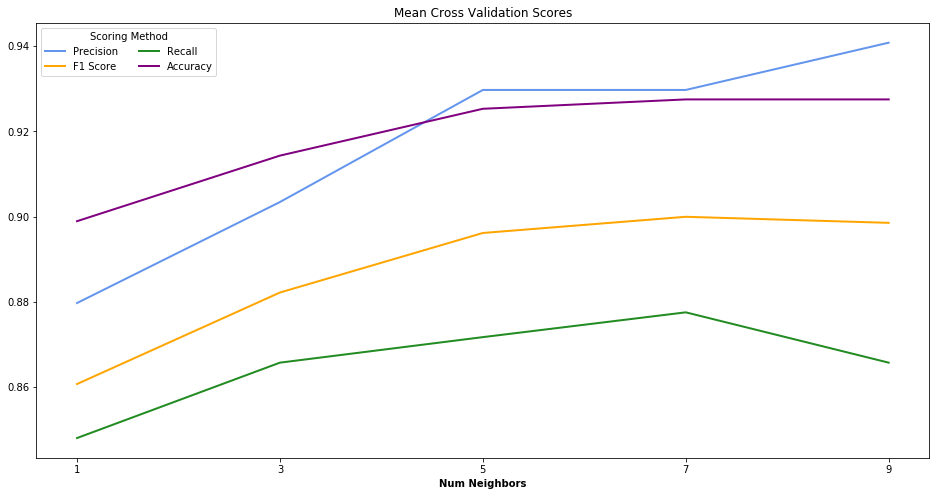

In [7]:
def plot_cv_scores(results):
    n = [int(x) for x in results['param_n_neighbors']]

    f1 = results['mean_test_f1']
    precision = results['mean_test_precision']
    recall = results['mean_test_recall']
    accuracy = results['mean_test_accuracy']

    fig = plt.figure(figsize=(16, 8))
    plt.plot(n, precision,
             color='cornflowerblue', label='Precision',
             linewidth=2)
    plt.plot(n, f1,
             color='orange', label='F1 Score',
             linewidth=2)
    plt.plot(n, recall,
             color='forestgreen', label='Recall',
             linewidth=2)
    plt.plot(n, accuracy,
             color='purple', label='Accuracy',
             linewidth=2)

    plt.xticks(n)
    plt.xlabel('Num Neighbors', fontweight='bold')
    plt.title('Mean Cross Validation Scores')
    plt.legend(title='Scoring Method', loc='best', ncol=2, frameon=True)
    
    plt.show()

plot_cv_scores(knn.cv_results_)

Then evaluate the model's performance on the test set.

In [8]:
y_pred_knn = knn.predict(X_test)
print_metrics(y_test, y_pred_knn)

    Confusion Matrix
                 Predict Positive    Predict Negative
Actual Positive         36                 5
Actual Negative         1                 72

Accuracy: 0.947

    Classification Report
           Positive    Negative
Num cases    41           73
Precision    0.97       0.94
Recall       0.88       0.99
F1 Score     0.92       0.96


As before, run 5-fold cross-validation on the entire dataset to evaluate the model's performance.  
F1, precision, recall, and accuracy scores are reported for each fold as well as the mean score across all folds.

In [9]:
knn_cv_scores = ms.cross_validate(knn, features, labels,
                                  cv=5, scoring=scoring)
print_cv_scores(knn_cv_scores)

    Cross Validation Scores
         F1     Precision    Recall    Accuracy
Fold 1   0.816    0.939      0.721     0.878
Fold 2   0.894    0.905      0.884     0.922
Fold 3   0.878    0.900      0.857     0.912
Fold 4   0.938    0.974      0.905     0.956
Fold 5   0.894    0.884      0.905     0.920

Mean F1: 0.884
Mean Precision: 0.920
Mean Recall: 0.854
Mean Accuracy: 0.918
